# Hello!
My name is Arshad Imrit and I'm submitting my assessment for the Data Science coding interview at Gemini, St. Michael

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as graph
import seaborn as sns
import os
import datetime
import itertools

import statsmodels.formula.api as smf
import statsmodels.api as sm

# Data Import
Here I am loading the datasets and quickly checking what they look like

In [2]:
admissions = pd.read_csv('/mnt/c/Users/imrit/Downloads/Gemini_ds_assessment/Admissions.csv')
lab = pd.read_csv('/mnt/c/Users/imrit/Downloads/Gemini_ds_assessment/Lab.csv')
tranfusions = pd.read_csv('/mnt/c/Users/imrit/Downloads/Gemini_ds_assessment/Transfusions.csv')

print(len(admissions))
display(admissions.head())

print(len(lab))
display(lab.head())

print(len(tranfusions))
display(tranfusions.head())

5231


,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score
0,3602,34208,2011-09-07,NaN,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1,45
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1,46
2,8755,97765,2002-08-24,14:28,08/27/2002,08:14,Mount Sinai Hospital,59.0,F,0,35
3,9260,17941,2007-01-12,09:39,01/26/2007,11:10,Sunnybrook Health Sciences Centre,57.0,M,1,18
4,5317,36532,2003-09-24,13:37,10/12/2003,16:23,Toronto Western Hospital,51.0,F,1,21


3609


,admission_id,test_name,test_code,result_unit,result_value,result_date,result_time
0,4416,Albumin,ALB,g/dL,4.1,2003-08-19,02:25
1,4636,Platelet Count,PLT,E9/L,295.0,2012-02-05,01:42
2,8041,Hemoglobin,RBC,g/L,165.4,2004-04-18,08:05
3,7384,Chloride plasma,CLPL,mmol/L,193.0,2000-04-04,14:55
4,2604,Albumin,ALB,g/dL,6.0,2008-02-01,11:30


657


,admission_id,issue_date,issue_time,rbc_transfusion,platelet_transfusion,plasma_transfusion
0,8755,2002-08-25,16:05,False,False,True
1,9736,2006-03-17,08:05,True,False,False
2,4152,2002-07-18,19:08,True,False,False
3,7077,2010-10-06,08:07,True,False,False
4,9297,2010-01-22,21:11,True,False,False


In [3]:
print(len(admissions['admission_id'].unique()), len(admissions['patient_id'].unique()))
print(len(lab['admission_id'].unique()))
print(len(tranfusions['admission_id'].unique()))

5231 5083
3609
657


So for the 'lab' and 'transfusion' dataset, each row is unique. For the 'admission' dataset, although each row has a unique admission_id, there are patients that have been admitted more than once. Something to be careful when working on the data

# Questions

### 1. Impute the missing charlson_comorbidity_index values in any way you see fit, with the intention that this variable will be used as a predictor in a statistical model.

Let's look at that column more in details, using values and graphs

In [4]:
print(admissions['charlson_comorbidity_index'].unique())

['1' '0' nan '2+']


The data here is not simply values. To better work with the data, I will convert the '2+' to 2, so that the whole column contains values only

[ 1.  0. nan  2.]
1.0    1818
2.0    1640
0.0    1512
NaN     261
Name: charlson_comorbidity_index, dtype: int64


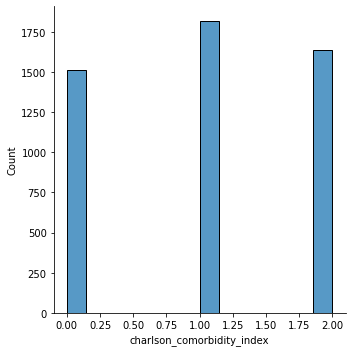

In [5]:
admissions['charlson_comorbidity_index'].replace('2+', 2, inplace=True)
admissions['charlson_comorbidity_index'] = admissions['charlson_comorbidity_index'].astype(float)
print(admissions['charlson_comorbidity_index'].unique())
print(admissions['charlson_comorbidity_index'].value_counts(dropna=False))

sns.displot(admissions['charlson_comorbidity_index'])
graph.show()

There are 261 empty values

We have a few options for imputation. The simplest way would be a mean impute, which works pretty well usually. We can also try median, zero-impute (fill all missing values with zero). Without knowing much more about the dataset, I cannot properly evaluate which imputation model would be better.

We will go with the mean imputation for now

In [6]:
admissions['charlson_comorbidity_index'].fillna(admissions['charlson_comorbidity_index'].mean().round(1), inplace=True)
print(admissions['charlson_comorbidity_index'].value_counts(dropna=False))

1.0    2079
2.0    1640
0.0    1512
Name: charlson_comorbidity_index, dtype: int64


This looks to be good. The data does not seem to have been overly biased (all categories remained in the same position, with 1 being the highest)

### 2. Determine if there is a significant difference in sex between patients who had an rbc_transfusion and patients that did not


Let's display the dataset again here, to refresh on what we are looking at again

In [7]:
display(tranfusions.head())

,admission_id,issue_date,issue_time,rbc_transfusion,platelet_transfusion,plasma_transfusion
0,8755,2002-08-25,16:05,False,False,True
1,9736,2006-03-17,08:05,True,False,False
2,4152,2002-07-18,19:08,True,False,False
3,7077,2010-10-06,08:07,True,False,False
4,9297,2010-01-22,21:11,True,False,False


We will need to merge this dataset with the admissions dataset, so that we can get the sex of the patients

In [8]:
transfusions_admissions = pd.merge(tranfusions, admissions, on='admission_id')
display(transfusions_admissions.head())

,admission_id,issue_date,issue_time,rbc_transfusion,platelet_transfusion,plasma_transfusion,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score
0,8755,2002-08-25,16:05,False,False,True,97765,2002-08-24,14:28,08/27/2002,08:14,Mount Sinai Hospital,59.0,F,0.0,35
1,9736,2006-03-17,08:05,True,False,False,74313,2006-03-09,13:51,03/26/2006,15:48,Sunnybrook Health Sciences Centre,NaN,F,0.0,10
2,4152,2002-07-18,19:08,True,False,False,70364,2002-07-04,08:11,07/22/2002,09:06,St. Michael's Hospital,61.0,M,1.0,3
3,7077,2010-10-06,08:07,True,False,False,19585,2010-09-27,10:37,10/13/2010,03:03,Toronto Western Hospital,58.0,F,2.0,50
4,9297,2010-01-22,21:11,True,False,False,61283,2010-01-19,NaN,01/28/2010,15:57,St. Joseph's Health Centre,59.0,F,1.0,7


Let's plot these columns, to see what we are looking at

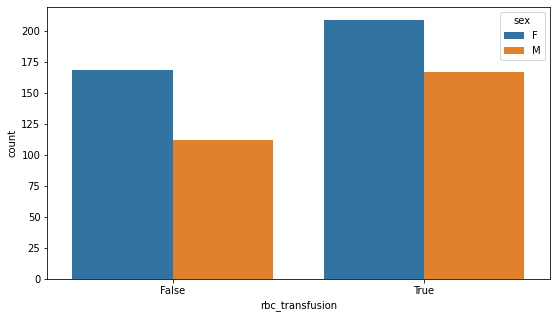

In [9]:
graph.figure(figsize=(9, 5))
sns.countplot(data = transfusions_admissions, x='rbc_transfusion', hue='sex')
graph.show()

We will use a contingency table and the Pearson's Chi Square test here to test the significance of these groups

In [10]:
contingency_table = sm.stats.Table.from_data(transfusions_admissions[['sex', 'rbc_transfusion']])

print('Observed Values')
display(contingency_table.table_orig)

print('Expected Values')
display(contingency_table.fittedvalues)

Observed Values


rbc_transfusion,False,True
sex,,
F,169,209
M,112,167


Expected Values


rbc_transfusion,False,True
sex,,
F,161.671233,216.328767
M,119.328767,159.671233


In [11]:
significance_test = contingency_table.test_nominal_association()
print(significance_test.pvalue)

0.24232839050126842


##### Answer:

Assuming alpha is 0.5 and given the p-value is greater than 0.5 (0.24), there is no significant difference in sex between patients who had a blood tranfusion and those who did not. 

We can try the test again when we have more data so that the results are more robust. However, we need to be careful of multiple testing

### 3. Fit a linear regression model using the result_value of the “Platelet Count” lab tests as the dependent variable and age, sex, and hospital as the independent variables. Briefly interpret the results.


We'll merge the lab and admission dataset here

In [12]:
lab_admissions = pd.merge(lab, admissions, on = 'admission_id')
display(lab_admissions.head())

,admission_id,test_name,test_code,result_unit,result_value,result_date,result_time,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score
0,4416,Albumin,ALB,g/dL,4.1,2003-08-19,02:25,22477,2003-08-10,08:04,08/19/2003,20:30,St. Michael's Hospital,54.0,M,1.0,7
1,4636,Platelet Count,PLT,E9/L,295.0,2012-02-05,01:42,72863,2012-01-30,09:13,02/06/2012,01:22,Toronto Western Hospital,NaN,M,0.0,23
2,8041,Hemoglobin,RBC,g/L,165.4,2004-04-18,08:05,99096,2004-04-04,01:06,04/22/2004,15:24,Sunnybrook Health Sciences Centre,43.0,M,0.0,1
3,7384,Chloride plasma,CLPL,mmol/L,193.0,2000-04-04,14:55,48781,2000-03-21,16:50,04/04/2000,15:57,Toronto Western Hospital,51.0,M,0.0,7
4,2604,Albumin,ALB,g/dL,6.0,2008-02-01,11:30,41491,2008-01-31,NaN,02/04/2008,12:15,St. Joseph's Health Centre,63.0,M,0.0,18


In [13]:
platelet_count_model = smf.ols(formula = 'result_value ~ age + sex + hospital', data = lab_admissions).fit()

print(platelet_count_model.summary())

                            OLS Regression Results                            
Dep. Variable:           result_value   R-squared:                       0.006
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     3.432
Date:                Tue, 14 Dec 2021   Prob (F-statistic):            0.00222
Time:                        12:08:13   Log-Likelihood:                -18984.
No. Observations:                3179   AIC:                         3.798e+04
Df Residuals:                    3172   BIC:                         3.802e+04
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

##### Answer:

The model has an adjusted R2 of 0.005, meaning that the model explains only 0.5% of the variation in the data, which is very low. The AIC is pretty high, but the AIC will not tell us anything when we are not comparing this model against another. 

The model is overall significant (p < 0.05). Looking at the independent variables, sex is a significant independent variable that affects the result_value. The age of the patients and the hospital of admissions are not significant, suggesting that these 2 variables do not influence the result of the lab test

### 4. Create one or multiple plots that demonstrate the relationships between length_of_stay (discharge date and time minus admission date and time), charlson_comorbidity_index, and age.


In [14]:
display(admissions.head())

,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score
0,3602,34208,2011-09-07,NaN,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1.0,45
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1.0,46
2,8755,97765,2002-08-24,14:28,08/27/2002,08:14,Mount Sinai Hospital,59.0,F,0.0,35
3,9260,17941,2007-01-12,09:39,01/26/2007,11:10,Sunnybrook Health Sciences Centre,57.0,M,1.0,18
4,5317,36532,2003-09-24,13:37,10/12/2003,16:23,Toronto Western Hospital,51.0,F,1.0,21


We'll create a length of stay column. First, we will convert the date and times column to date formats, so that they are easier to work with. We will also fill in missing values for admission time and discharge time, assuming midnight (00:00)

In [15]:
admissions['admission_time'].fillna('00:00', inplace=True)
admissions['discharge_time'].fillna('00:00', inplace=True)

for col, date, time in zip(['admission_dt', 'discharge_dt'], 
                           ['admission_date', 'discharge_date'], 
                           ['admission_time', 'discharge_time']):
    admissions[col] = pd.to_datetime(admissions[date] + ' ' + admissions[time])

display(admissions.head())

,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,admission_dt,discharge_dt
0,3602,34208,2011-09-07,00:00,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1.0,45,2011-09-07 00:00:00,2011-09-11 13:16:00
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1.0,46,2008-07-22 06:19:00,2008-07-24 17:54:00
2,8755,97765,2002-08-24,14:28,08/27/2002,08:14,Mount Sinai Hospital,59.0,F,0.0,35,2002-08-24 14:28:00,2002-08-27 08:14:00
3,9260,17941,2007-01-12,09:39,01/26/2007,11:10,Sunnybrook Health Sciences Centre,57.0,M,1.0,18,2007-01-12 09:39:00,2007-01-26 11:10:00
4,5317,36532,2003-09-24,13:37,10/12/2003,16:23,Toronto Western Hospital,51.0,F,1.0,21,2003-09-24 13:37:00,2003-10-12 16:23:00


In [16]:
admissions['length_of_stay'] = (admissions['discharge_dt'] - admissions['admission_dt']).dt.days
display(admissions.head())

,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,admission_dt,discharge_dt,length_of_stay
0,3602,34208,2011-09-07,00:00,09/11/2011,13:16,St. Joseph's Health Centre,NaN,M,1.0,45,2011-09-07 00:00:00,2011-09-11 13:16:00,4
1,2790,90930,2008-07-22,06:19,07/24/2008,17:54,St. Michael's Hospital,48.0,M,1.0,46,2008-07-22 06:19:00,2008-07-24 17:54:00,2
2,8755,97765,2002-08-24,14:28,08/27/2002,08:14,Mount Sinai Hospital,59.0,F,0.0,35,2002-08-24 14:28:00,2002-08-27 08:14:00,2
3,9260,17941,2007-01-12,09:39,01/26/2007,11:10,Sunnybrook Health Sciences Centre,57.0,M,1.0,18,2007-01-12 09:39:00,2007-01-26 11:10:00,14
4,5317,36532,2003-09-24,13:37,10/12/2003,16:23,Toronto Western Hospital,51.0,F,1.0,21,2003-09-24 13:37:00,2003-10-12 16:23:00,18


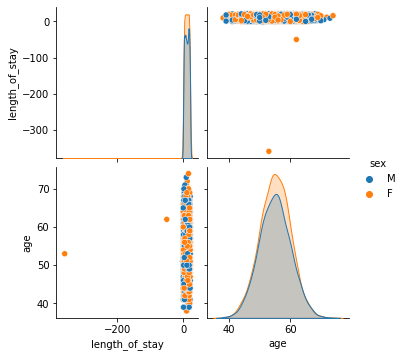

In [17]:
sns.pairplot(admissions[['length_of_stay', 'age', 'sex']], hue='sex')
graph.show()

Okay so it seems like there's a mistake in the data, where we are having negative length of stays. This would mean that the patient was discharged before being admitted! Let's look at that

In [18]:
display(admissions.loc[admissions['length_of_stay'] < 0])

,admission_id,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,admission_dt,discharge_dt,length_of_stay
283,6023,67135,2001-06-26,15:05,05/08/2001,14:46,Mount Sinai Hospital,62.0,F,0.0,36,2001-06-26 15:05:00,2001-05-08 14:46:00,-50
3204,8968,56952,2008-09-22,10:52,09/28/2007,19:28,St. Michael's Hospital,53.0,F,1.0,7,2008-09-22 10:52:00,2007-09-28 19:28:00,-360
3375,5643,82989,2001-11-13,16:44,11/13/2001,14:43,Toronto Western Hospital,56.0,M,0.0,51,2001-11-13 16:44:00,2001-11-13 14:43:00,-1
4773,7801,79979,2010-05-13,12:46,05/11/2010,20:28,Sunnybrook Health Sciences Centre,51.0,M,2.0,20,2010-05-13 12:46:00,2010-05-11 20:28:00,-2


We indeed have these errors in the data. At this point, I will assume these are erroneous data entry and ignore them for now. At a later time, we can look at these more in detail

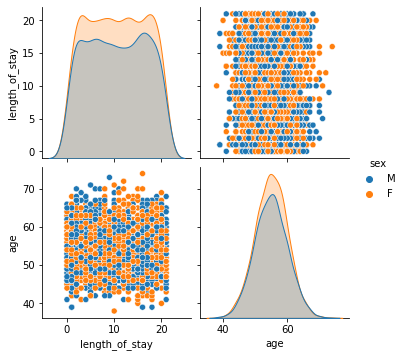

In [19]:
admissions_stays = admissions.loc[admissions['length_of_stay'] >= 0]

sns.pairplot(admissions_stays[['length_of_stay', 'age', 'sex']], hue='sex')
graph.show()

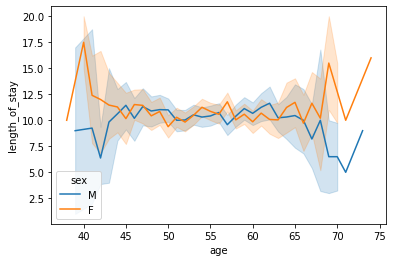

In [20]:
sns.lineplot(data = admissions_stays, x = 'age', y = 'length_of_stay', hue = 'sex')
graph.show()

### 5. You are interested in evaluating the effect of platelet transfusions on a disease. The patients with platelet_transfusion represent the selected treatment group. Select a control group in any way you see fit. 

##### Answer: 
An adequate group, given what I currently know of the data, would be patient who have the diseases but did not receive the platelet transfusion treatment. Hence, we will be keeping the condition the same but changing the treatment.

### How could you improve your selection if you had more data and access to any clinical variable you can think of?

##### Answer: 
I would need to know if the patients who did not receive the platelet transfusion and if they did not receive other treatments. If they did, then there will be confounding factors and this treatment group would not be appropriate.
We should also try to minimize the effect of all other variables, such as age, sex, time of diseases onset. By controlling for these, we can reduce the effect of these confounding variables and be more certain that we will be looking at the effect of the treatment (platelet transfusion only)


### 6. Fit a first-iteration statistical model of your choosing to predict the result_value of the “Hemoglobin” lab tests and evaluate its performance.

We will first subset the data so that we include only Hemoglobin tests

In [21]:
lab_hemo = lab.loc[lab['test_name'] == 'Hemoglobin']
display(lab_hemo)

,admission_id,test_name,test_code,result_unit,result_value,result_date,result_time
2,8041,Hemoglobin,RBC,g/L,165.4,2004-04-18,08:05
5,8049,Hemoglobin,RBC,g/L,164.4,2014-10-12,03:21
8,2338,Hemoglobin,RBC,g/L,158.2,2000-01-18,07:07
12,3751,Hemoglobin,RBC,g/L,154.2,2010-12-23,17:13
16,8262,Hemoglobin,RBC,g/L,115.7,2000-01-09,02:19
...,...,...,...,...,...,...,...
3591,8108,Hemoglobin,RBC,g/L,118.6,2008-08-25,04:07
3592,8120,Hemoglobin,RBC,g/L,158.5,2001-09-15,13:03
3595,2777,Hemoglobin,RBC,g/L,135.0,2014-01-26,04:41
3598,1448,Hemoglobin,RBC,g/L,144.8,2008-10-25,02:37


In [22]:
lab_hemo['result_unit'].unique()

array(['g/L', 'g/dL'], dtype=object)

The units are not the same here. Let's correct this

In [23]:
lab_hemo['result_value'] = np.where(lab_hemo['result_unit'] == 'g/dL', lab_hemo['result_value'] / 0.1, lab_hemo['result_value'])
lab_hemo['result_unit'] = 'g/L'
display(lab_hemo)

/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/arshad/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,admission_id,test_name,test_code,result_unit,result_value,result_date,result_time
2,8041,Hemoglobin,RBC,g/L,165.4,2004-04-18,08:05
5,8049,Hemoglobin,RBC,g/L,164.4,2014-10-12,03:21
8,2338,Hemoglobin,RBC,g/L,158.2,2000-01-18,07:07
12,3751,Hemoglobin,RBC,g/L,154.2,2010-12-23,17:13
16,8262,Hemoglobin,RBC,g/L,115.7,2000-01-09,02:19
...,...,...,...,...,...,...,...
3591,8108,Hemoglobin,RBC,g/L,118.6,2008-08-25,04:07
3592,8120,Hemoglobin,RBC,g/L,158.5,2001-09-15,13:03
3595,2777,Hemoglobin,RBC,g/L,135.0,2014-01-26,04:41
3598,1448,Hemoglobin,RBC,g/L,144.8,2008-10-25,02:37


Now that we have only the Hemoglobin tests and we corrected the unit, let's merge this data with the admission dataset, so that we can use some of the predictor variables from that dataset

In [24]:
lab_hemo_admission = pd.merge(lab_hemo, admissions, on = 'admission_id')
display(lab_hemo_admission.head())

,admission_id,test_name,test_code,result_unit,result_value,result_date,result_time,patient_id,admission_date,admission_time,discharge_date,discharge_time,hospital,age,sex,charlson_comorbidity_index,lap_score,admission_dt,discharge_dt,length_of_stay
0,8041,Hemoglobin,RBC,g/L,165.4,2004-04-18,08:05,99096,2004-04-04,01:06,04/22/2004,15:24,Sunnybrook Health Sciences Centre,43.0,M,0.0,1,2004-04-04 01:06:00,2004-04-22 15:24:00,18
1,8049,Hemoglobin,RBC,g/L,164.4,2014-10-12,03:21,89502,2014-10-06,21:02,10/19/2014,14:37,St. Michael's Hospital,61.0,F,0.0,38,2014-10-06 21:02:00,2014-10-19 14:37:00,12
2,2338,Hemoglobin,RBC,g/L,158.2,2000-01-18,07:07,58877,2000-01-13,10:51,01/18/2000,16:10,Mount Sinai Hospital,NaN,M,1.0,58,2000-01-13 10:51:00,2000-01-18 16:10:00,5
3,3751,Hemoglobin,RBC,g/L,154.2,2010-12-23,17:13,21106,2010-12-16,20:42,12/26/2010,09:11,St. Michael's Hospital,54.0,F,1.0,58,2010-12-16 20:42:00,2010-12-26 09:11:00,9
4,8262,Hemoglobin,RBC,g/L,115.7,2000-01-09,02:19,81979,2000-01-06,04:31,01/18/2000,10:24,Mount Sinai Hospital,48.0,F,2.0,3,2000-01-06 04:31:00,2000-01-18 10:24:00,12


I would like to test how the charlson_comorbodity_index, age, sex and lap_score affects the result.
Since we have to evaluate the model performance, we'll use a train test split technique so that we can test the model on the test set, which it would have never seen 

In [25]:
predictors_target = lab_hemo_admission[['age', 'sex', 'charlson_comorbidity_index', 'lap_score', 'result_value']]

train = predictors_target.sample(frac=0.8)
test =  predictors_target.loc[~predictors_target.index.isin(list(train.index))]

In [26]:
hemo_lm = smf.ols(formula = 'result_value ~ age + sex + charlson_comorbidity_index + lap_score', 
                  data = train).fit()
display(hemo_lm.summary())

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           result_value   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     4.946
Date:                Tue, 14 Dec 2021   Prob (F-statistic):           0.000623
Time:                        12:08:24   Log-Likelihood:                -2963.6
No. Observations:                 642   AIC:                             5937.
Df Residuals:                     637   BIC:                             5960.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                    142.6577     10.863     13.133      0.000     121.327     163.989
sex[T.M]                       8.3792      1.952      4.292      0.000       4.546      12.213
age                           -0.0766      0.194     -0.394      0.694      -0.458       0.305
charlson_comorbidity_index    -1.4715      1.256     -1.172      0.242      -3.938       0.995
lap_score                      0.0096      0.047      0.203      0.839      -0.083       0.103
==============================================================================
Omnibus:                        3.388   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.184   Jarque-Bera (JB):                3.202
Skew:                           0.148   Prob(JB):                        0.202
Kurtosis:                       3.180   Cond. No.                         701.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

We will use the rmse to evalue the models

In [27]:
y_predicted = hemo_lm.predict(test)

In [28]:
rmse_lm =  np.sqrt(np.nansum((y_predicted.values - test['result_value'].values) ** 2)) / len(test)
rmse_lm

1.693513336288297

### How could you improve the model if you had more data and access to any clinical variable you can think of?

I would be able to use more interesting models, such as boosted regressions, random forest regressions